#### Loading data sources

In [468]:
!pip install imblearn
!pip install imbalanced-learn
!pip install patsy

Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple


In [469]:
# This Jupyter Notebook does feature engineering joining all features in all tables.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
import torch


# Preprocessing

In [470]:
# Read employees dataset
df_customer_raw = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [471]:
df_customer_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [472]:
df_customer = df_customer_raw

In [473]:
df_customer['TotalCharges'] = pd.to_numeric(df_customer['TotalCharges'], errors='coerce')

In [474]:
df_customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Encoding

In [475]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

In [476]:
label_encoded_fields = [ 'Partner', 'Dependents', 'PhoneService', 'Churn', 'PaperlessBilling' ]
one_hot_encoded_fields = [ 'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'StreamingTV', 'Contract', 'PaymentMethod' ]

### Label Encoding

In [477]:
print('Before Label Encoding')

for field in label_encoded_fields:
    print(field)
    print(df_customer[field].unique())

Before Label Encoding
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
PhoneService
['No' 'Yes']
Churn
['No' 'Yes']
PaperlessBilling
['Yes' 'No']


In [478]:
print('After Label Encoding')

for field in label_encoded_fields:
    df_customer[field] = le.fit_transform(df_customer[field])
    print(f'Field: {field}')
    print(df_customer[field].unique())

After Label Encoding
Field: Partner
[1 0]
Field: Dependents
[0 1]
Field: PhoneService
[0 1]
Field: Churn
[0 1]
Field: PaperlessBilling
[1 0]


### One Hot Encoding

In [479]:
print('Before One Hot Encoding')

for field in one_hot_encoded_fields:
    print(field)
    print(df_customer[field].unique())

Before One Hot Encoding
gender
['Female' 'Male']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [480]:
print('After One Hot Encoding')

for field in one_hot_encoded_fields:
    encoded_data = ohe.fit_transform(df_customer[[field]])
    encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out([field]))
    df_customer = pd.concat([df_customer, encoded_df], axis=1)
    df_customer.drop(columns=[field], inplace=True)


df_customer.info()

After One Hot Encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7043 non-null   object 
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   PaperlessBilling                         7043 non-null   int64  
 7   MonthlyCharges                           7043 non-null   float64
 8   TotalCharges                             7032 non-null   float64
 9   Churn                                    7043 non-null   int64  
 10  gender_Female            

In [481]:
df_customer

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,1,1,24,1,1,84.80,1990.50,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,2234-XADUH,0,1,1,72,1,1,103.20,7362.90,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,4801-JZAZL,0,1,1,11,0,1,29.60,346.45,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,8361-LTMKD,1,1,0,4,1,1,74.40,306.60,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [482]:
df_customer.drop(columns=['customerID'], inplace=True)

In [483]:
df_customer

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,34,1,0,56.95,1889.50,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,2,1,1,53.85,108.15,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,45,0,0,42.30,1840.75,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,2,1,1,70.70,151.65,1,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,1,1,84.80,1990.50,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,1,1,72,1,1,103.20,7362.90,0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,1,1,11,0,1,29.60,346.45,0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,0,4,1,1,74.40,306.60,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [484]:
df_customer.dropna(inplace=True)

In [485]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7032 non-null   int64  
 1   Partner                                  7032 non-null   int64  
 2   Dependents                               7032 non-null   int64  
 3   tenure                                   7032 non-null   int64  
 4   PhoneService                             7032 non-null   int64  
 5   PaperlessBilling                         7032 non-null   int64  
 6   MonthlyCharges                           7032 non-null   float64
 7   TotalCharges                             7032 non-null   float64
 8   Churn                                    7032 non-null   int64  
 9   gender_Female                            7032 non-null   float64
 10  gender_Male                              7032 no

## Correlation analysis

In [486]:
corr_matrix = df_customer.corr()
churn_corr = corr_matrix['Churn']
highly_positive_corr_features = churn_corr[churn_corr > 0.3].sort_values(ascending=False)
print('Highly positive correlated features')
print(highly_positive_corr_features)

Highly positive correlated features
Churn                             1.000000
Contract_Month-to-month           0.404565
OnlineSecurity_No                 0.342235
TechSupport_No                    0.336877
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
Name: Churn, dtype: float64


In [487]:
print('Highly negative correlated features')
highly_negative_corr_features = churn_corr[churn_corr < -0.3].sort_values(ascending=True)
print(highly_negative_corr_features)

Highly negative correlated features
tenure              -0.354049
Contract_Two year   -0.301552
Name: Churn, dtype: float64


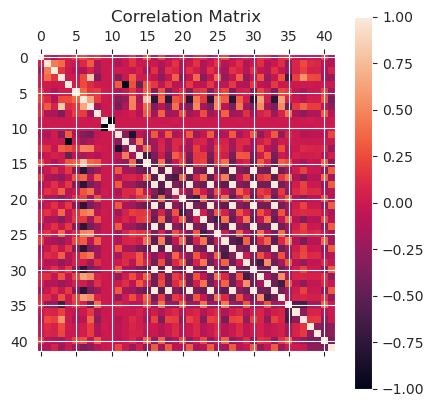

<Figure size 1000x600 with 0 Axes>

In [488]:
plt.matshow(corr_matrix)
plt.colorbar()
plt.title('Correlation Matrix')
plt.figure(figsize=(10, 6))
plt.show()

# Models

In [489]:
X = df_customer.drop(columns=['Churn'])  # All features
X = df_customer[['tenure', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']]
y = df_customer['Churn']  # Target variable
random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

## XGBoost

In [490]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=1000, random_state=random_state)
xgb_model.fit(X_train, y_train)
y_predicted = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
report = classification_report(y_test, y_predicted)

print('XGBoost Classifier')
print(report)

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.59      0.49      0.53       374

    accuracy                           0.77      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.77      0.77      1407



## RandomForest

In [491]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
y_predicted = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
report = classification_report(y_test, y_predicted)

print('RandomForest Classifier')
print(report)

RandomForest Classifier
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1033
           1       0.54      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407



## Logistic Regression


In [492]:
lr_model = LogisticRegression(random_state=random_state, max_iter=1000000)
lr_model.fit(X_train, y_train)
y_predicted = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
report = classification_report(y_test, y_predicted)

print('LogisticRegression Classifier')
print(report)

LogisticRegression Classifier
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



## Neural Network

In [493]:
from feed_forward_nn import NeuralNetwork

model = NeuralNetwork(2, 10, 3)

# Train the model on some data

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    # Forward pass
    y_pred = model(X_train)

    # Calculate the loss
    loss = torch.nn.functional.cross_entropy(y_pred, y)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Make a prediction on some new data
X_new = torch.tensor([[5, 6]])
prediction = model(X_new)

# Print the prediction
print(prediction)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
# rfe = RFE(rf_model, n_features_to_select=10)
# rfe = rfe.fit(X_train, y_train)
# selected_features = X.columns[rfe.support_]
# print(selected_features)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=test_size, random_state=random_state)

In [ ]:
# rf_model.fit(X_train, y_train)
# y_predicted = rf_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_predicted)
# report = classification_report(y_test, y_predicted)
# print(report)